In [1]:

import arviz as az
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pymc3 as pm




/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
raw_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education-categorical",
        "educ",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "captial-gain",
        "capital-loss",
        "hours",
        "native-country",
        "income",
    ],
)

In [3]:
raw_data.head(10)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## Подготовим данные

In [4]:
data = raw_data[~pd.isnull(raw_data["income"])]


In [5]:
data[data["native-country"] == " United-States"].sample(5)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
6871,35,Private,337286,Masters,14,Never-married,Exec-managerial,Not-in-family,Asian-Pac-Islander,Male,0,0,40,United-States,<=50K
2283,27,Local-gov,29174,Bachelors,13,Never-married,Prof-specialty,Unmarried,White,Female,0,0,40,United-States,<=50K
6468,34,Private,204470,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
19531,39,Self-emp-inc,135500,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1977,40,United-States,>50K
14768,32,Local-gov,198211,Assoc-voc,11,Married-spouse-absent,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [6]:
income = 1 * (data["income"] == " >50K")

In [7]:
data = data[["age", "educ", "hours","marital-status"]]

# Scale age by 10, it helps with model convergence.
data["age"] = data["age"] / 10.0
data["age2"] = np.square(data["age"])
data["income"] = income

income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [8]:
def replace_marital(marital):
    if 'married' in marital.lower():
        return 4
    elif 'single' in marital.lower():
        return 3
    elif 'divorced' in marital.lower():
        return 2
    elif 'unknown' in marital.lower():
        return 1
    
data['marital'] = data["marital-status"].apply(lambda x: replace_marital(x))

data['marital'].fillna(1, inplace=True)

/opt/conda/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/opt/conda/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


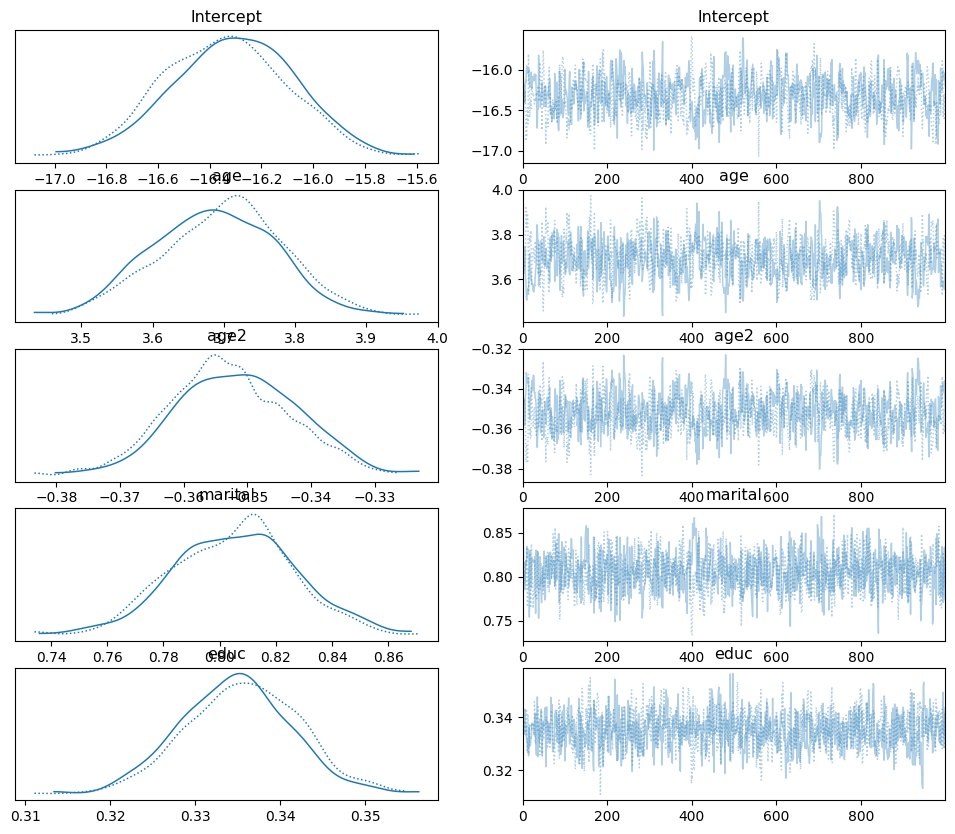

In [9]:


with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('income ~ age + age2 + marital + educ ', data, family = pm.glm.families.Binomial())
    trace = pm.sample(1000)
    
az.plot_trace(trace);

<Figure size 900x700 with 0 Axes>

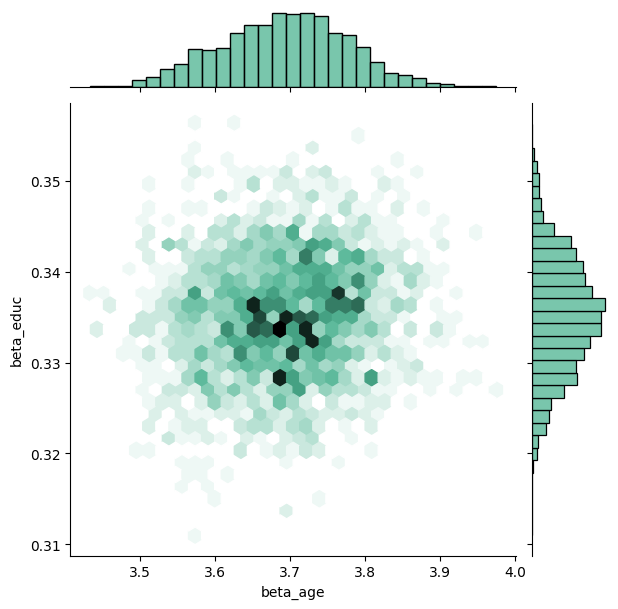

In [13]:
import seaborn as sns
plt.figure(figsize=(9, 7))
sns.jointplot(x=trace["age"], y=trace["educ"], kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_educ");

Итак, влияют ли возраст и образование на вероятность заработать больше, чем 50К? 

Чтобы ответить на этот вопрос мы покажем, что вероятность получить больше 50K меняется с возрастом и семейным положением для нескольких уровней образования. 

PyMC3 дает нам удобный способ построить апостериорное прогнозирующее распределение. Нам нужно передать функции линейную модель и набор точек для оценки. Мы перейдем к трем различным линейным моделям: одна с образованием == 12 (законченная средняя школа), одна с образованием == 16 (окончание бакалавриата) и одна с образованием == 19 (трехгодичная аспирантура).

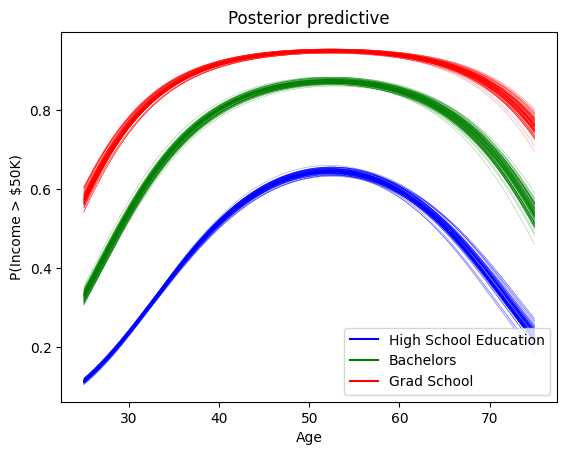

In [16]:
def lm_full(trace, age, education, marital):
    shape = np.broadcast(age, education, marital).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [age/10., education, marital]])
    
    return 1 / (1 + np.exp(-(trace['Intercept'] + 
                             trace['age']*x_norm[0] + 
                             trace['age2']*(x_norm[0]**2) +
                             trace['educ']*x_norm[1] +
                             trace['marital']*x_norm[2])))

lm = lambda x, samples: lm_full(samples, x, 12., 4.)
lm2 = lambda x, samples: lm_full(samples, x, 16., 4.)
lm3 = lambda x, samples: lm_full(samples, x, 19., 4.)


pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm, samples=100, color='blue', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm2, samples=100, color='green', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm3, samples=100, color='red', alpha=.8)

blue_line = plt.Line2D(["lm"], [], color="b", label="High School Education")
green_line = plt.Line2D(["lm2"], [], color="g", label="Bachelors")
red_line = plt.Line2D(["lm3"], [], color="r", label="Grad School")
plt.legend(handles=[blue_line, green_line, red_line], loc="lower right")
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")
plt.show();

Каждая кривая показывает, насколько вероятность заработать больше, чем 50K меняется с возрастом. Красная кривая представляет 19 лет образования, зеленая кривая представляет 16 лет образования, а синяя кривая представляет 12 лет образования. Для всех трех уровней образования вероятность заработка более 50 тысяч долларов увеличивается с возрастом примерно до 60 лет, когда вероятность начинает снижаться. Обратите внимание, что каждая кривая немного размыта. Это потому, что мы фактически строим 100 различных кривых для каждого уровня образования. Каждая кривая является результатом нашего апостериорного распределения. Поскольку кривые в некоторой степени полупрозрачны, мы можем интерпретировать темные узкие участки кривой как места, где у нас низкая неопределенность, а светлые, расширенные участки кривой - как места, где у нас есть несколько более высокая неопределенность в отношении значений наших коэффициентов.

In [17]:
pm.summary(trace)

/opt/conda/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-16.322,0.237,-16.734,-15.862,0.010,0.007,523.0,823.0,1.00
age,3.693,0.086,3.530,3.848,0.004,0.003,535.0,788.0,1.01
age2,-0.352,0.009,-0.368,-0.334,0.000,0.000,552.0,823.0,1.01
marital,0.805,0.021,0.766,0.846,0.001,0.000,961.0,869.0,1.00
educ,0.335,0.007,0.322,0.347,0.000,0.000,1035.0,1041.0,1.01


## Сравнение с линейной регрессией

In [30]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(data[['age', 'educ',  'age2', 'marital']], data['income'])

LinearRegression()

In [31]:
lr.intercept_

-1.4492242625165206

In [35]:
pd.DataFrame(lr.coef_, index=['age', 'educ',  'age2', 'marital'])

,0
age,0.366104
educ,0.046227
age2,-0.032859
marital,0.102171
